# **PSO vs Random Walk**: Aplicações no problema de roteamento de veículos capacitados

## Sumário

1. [Introdução](#Introdução)
2. [O módulo `cvrp`](#O-módulo-cvrpy)
3. LoggiBUD
4. OSRM - Open Street Machine Routing
2. Testes experimentais
    - Codificação
    - Random Walk
    - Particle Swarm

# Introdução

<p style="font-size: 12pt">
O problema de roteamento de veículos é um problema de classe NP-Difícil de
grande interesse da indústria, devido à sua importância para o setor de
logística é um problema amplamente estudado por pesquisadores de todo o mundo no
campo de otimização combinatória e pesquisa operacional.
</p>

<p style="font-size: 12pt">
No problema de roteamento de veículos existe um depósito de onde partem um
conjunto de veículos, um conjunto finito de entregas devem ser feitas e cada
entrega possui um peso e estão distribuídas em um plano e interconectadas (um
grafo). O objetivo é encontrar um solução onde cada veículo tenha uma rota que
parte do depósito, atende um conjunto de entregas sem que uma mesma e retorna
para o depósito sem que uma mesma entrega esteja em duas rotas diferentes e com
a menor distância total percorrida pelos veículos. Existem uma variação desse
problema que adiciona uma restrição: os veículos possuem uma capacidade de carga
limitada e o conjunto de entregas que um veículo atende não pode ter um peso
total maior do que a capacidade do veículo, essa variação é chamada de
<strong>problema do roteamento de veículos capacitados</strong>.
</p>

<img
  src="https://d3i71xaburhd42.cloudfront.net/8e2f197670ab5f20c13ed8a0197e26f713663f81/2-Figure1-1.png"
  width="240"
/>

<p style="font-size: 12pt">
Esse trabalho buscar analisar a aplicação de duas técnicas de otimização
distintas, o algoritmo de Random Walk e o algoritmo de otimização por enxame de
partículas (PSO - <i>Particle Swarm Optimization</i>), demonstrando suas
diferenças e as vantagens da utilização de uma sobre a outra.
</p>

## O módulo `cvrpy`

<p style="font-size: 12pt">
Esse trabalho implementa os algoritmo e modelagens em Python e foi organizado
como um módulo chamado de <code>cvrpy</code> que pode ser importado abstraindo as
implementações de seu uso.
O módulo fornece classes para a criação de vetores codificando as soluções para
o problema tanto para o Random Walk (com a class <code>Individual</code>) com
para o PSO (com a class <code>Particle</code>). Oferece também as implementações
dos dois algoritmos e uma API simples para executá-los, apenas instanciando um
objeto com os parâmteros do algoritmo e executando um método, um simples
<code>randomwalk.run(until=100)</code> é o suficiente para executar.
</p>

<p style="font-size: 12pt">
Além disso, o módulos também abstrai a modelagem do problema e as funções que
usam o <a href="http://project-osrm.org/">serviço OSRM</a> (que deve ser rodado
em background) para calcular distâncias entre pontos no mapa considerando as
rodovias entre eles.

## LoggiBUD

<p style="font-size: 12pt">
O projeto foi desenvolvido usando as instâncias e recursos fornecidos pelo
<a href="https://github.com/loggi/loggibud">LoggiBUD</a> (Loggi Benchmark for
Urban Deliveries) criado por engenheiros da <a href="https://loggi.com">Loggi</a>
que fornece instâncias do problema de roteamento de veículos mais próximas dos
problemas enfrentados na indústria de logística e com informações geográficas de
cidades brasileiras. Mais informações podem ser consultadas no repositório
oficial no Github em
<a href="https://github.com/loggi/loggibud">https://github.com/loggi/loggibud</a>.
</p>

## OSRM - Open Street Machine Routing

<p style="font-size: 12pt">
O OSRM é um motor de roteamento baseado em dados do <strong>Open Street Maps</strong>
que fornece uma API HTTP para vários tipos de operações com informações
geográficas. É usado nesse projeto para calcular as distâncias entre dois pontos
no mapa fornecendo um meio de calcular o fitness de uma solução, ou seja, de
dizer a distância total percorrida em uma solução definida por uma partícula/indivíduo.
</p>

<p style="font-size: 12pt">
O seguinte comando deve ser usado para subir um container Docker do OSRM em
background antes de executar qualquer experimento com um dos algoritmos.
</p>

<p><code>docker run --rm -t -id --name osrm -p 5000:5000 -v "${PWD}/osrm:/data" osrm/osrm-backend:v5.24.0 osrm-routed --algorithm ch /data/brazil-201110.osrm --max-table-size 10000</code></p>

<p style="font-size: 12pt">
Mais informações sobre a ferramenta podem ser encontradas em
<a href="http://project-osrm.org">http://project-osrm.org</a>.

In [1]:
# Descomente a linha abaixo para executar o container
# !docker run --rm -t -id --name osrm -p 5000:5000 -v "${PWD}/osrm:/data" osrm/osrm-backend:v5.24.0 osrm-routed --algorithm ch /data/brazil-201110.osrm --max-table-size 10000

# Testes experimentais

<p style="font-size: 12pt">
Para executar os testes para gerar resultados foram utilizadas três instâncias
do problema obtidas do LoggiBUD todas baseadas em informações geográficas no
estado do Pará.
</p>

<p style="font-size: 12pt">
O LoggiBUD armazena as informações de instâncias como arquivos JSON e fornece
uma classe Python para carregar as informações do arquivo diretamente em uma
estrutura de dados. As três instâncias escolhidas foram:

1. `pa-0/pa-101`
2. `pa-0/pa-102`
3. `pa-0/pa-103`

In [2]:
from loggibud.v1.types import CVRPInstance

problem = CVRPInstance.from_file('data/cvrp_castanhal.json')
print(f'{len(problem.deliveries)} entregas. Capacidade máx. por veículo: {problem.vehicle_capacity}')

35 entregas. Capacidade máx. por veículo: 180


In [3]:
# Pré-definições
from typing import List, Union
from cvrpy.rw import Individual
from cvrpy.pso import Particle

NUM_SOLUTIONS=100
NUM_ITERATIONS=20
NUM_VEHICLES=30

class ExperimentResult:
    num_executions: int
    solutions: Union[List[Particle], List[Individual]]
    convergences: List

    def __init__(self):
        self.num_executions = 0
        self.solutions = []
        self.convergences = []

    def append(self, solution: Union[Particle, Individual], convergence: List):
        self.solutions.append(solution)
        self.convergences.append(convergence)
        self.num_executions += 1


## Random Walk

In [6]:
from cvrpy.rw import RandomWalk

def execute_random_walk_experiment(
    problem: CVRPInstance,
    num_executions: int,
    num_individuals: int,
    num_iterations: int,
    num_vehicles: int
) -> ExperimentResult:
    rw = RandomWalk(num_individuals=num_individuals)
    result = ExperimentResult()
    for _ in range(num_executions):
        solution = rw.run(num_iterations, problem, num_vehicles)
        convergence = rw.get_convergence().copy()
        result.append(solution, convergence)
    return result

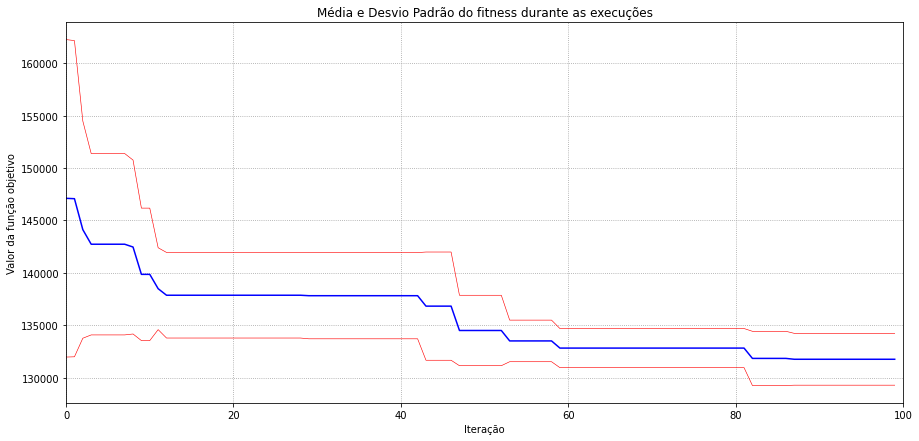

In [5]:
from cvrpy.plotting import Plotter

res = execute_random_walk_experiment(
    problem=problem,
    num_executions=5,
    num_individuals=40,
    num_iterations=100,
    num_vehicles=5
)

fig, axes = Plotter.plot_convergence(res.convergences)
fig.savefig('RandomWalk-cvrp-0-pa-101.png')

In [7]:
from cvrpy.pso import PSO

def execute_pso_experiment(
    problem: CVRPInstance,
    num_executions: int,
    num_particles: int,
    num_iterations: int,
    num_vehicles: int
) -> ExperimentResult:
    pso = PSO(problem, num_particles, num_vehicles)
    result = ExperimentResult()
    for _ in range(num_executions):
        solution = pso.optimize(until=num_iterations)
        result.append(solution, pso.convergence.copy())
    return result

In [ ]:
from cvrpy.plotting import Plotter

res_pso = execute_pso_experiment(
    problem=problem,
    num_executions=5,
    num_particles=40,
    num_iterations=100,
    num_vehicles=5
)

pso_fig, pso_axes = Plotter.plot_convergence(res.convergences)
pso_fig.savefig('PSO-cvrp-0-pa-101.png')